### Let's play with LSTM's
In this notebook I will explore lstms for the task of time seq generation. Time sequence generation is a really important task in robotics, especially if you are dealing with trajectory predictions. 

In [377]:
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

#### Generating a sine wave
We will want our network to learn a sine wave. For that we will need to generate multiple sequences of a sine wave. 

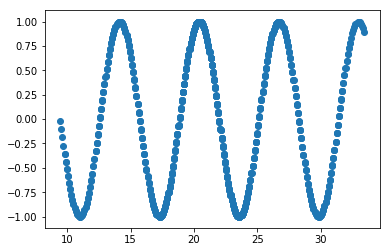

In [416]:
def generate_sample(batch_size = 6, seqlength = 1000, show_plot=False):
    lower = np.random.randint(-100, 100, size=batch_size)
    higher = lower + 1000
    x = np.linspace(lower, higher, seqlength)
    x = (x * np.pi/180 *5).reshape(batch_size, seqlength)
    y = np.sin(x)
#     print(x[0].shape, y[0].shape)
    if show_plot:
        plt.scatter(x[1], y[1])
        plt.show()
    return torch.from_numpy(y.reshape(seqlength, batch_size, 1)).float()

input = generate_sample(show_plot=True)

#### Defining Network Related Stuff

In [417]:
epochs = 10
num_samples = 10
batch_size = 10
seqlength = 1000

#### Defining the LSTM model 
We will use two stacked lstm for this task. 

In [482]:
class network(nn.Module):
    def __init__(self, hidden_size=51):
        super(network, self).__init__()
        self.hidden_size = hidden_size
        self.lstm1 = nn.LSTMCell(input_size=1, hidden_size=self.hidden_size)
        self.lstm2 = nn.LSTMCell(input_size=self.hidden_size, hidden_size=self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, 1)
        self.sig = nn.Sigmoid()
    
    def forward(self, input):
        outputs = []
        batch_size = input.shape[0]
        seqlength = input.shape[1]
        ct1 = torch.zeros((batch_size, self.hidden_size))
        ht1 = torch.zeros((batch_size, self.hidden_size))
        ct2 = torch.zeros((batch_size, self.hidden_size))
        ht2 = torch.zeros((batch_size, self.hidden_size))
#         for i in range(seqlength):
#             ht1, ct1 = self.lstm1(input[i], (ht1, ct1))
#             ht2, ct2 = self.lstm2(ht1, (ht2, ct2))
#             out = self.linear(ht2)
#             outputs += [out]
            
        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            ht1, ct1 = self.lstm1(input_t, (ht1, ct1))
            ht2, ct2 = self.lstm2(ht1, (ht2, ct2))
            output = self.linear(ht2)
            outputs += [output]
        
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

#### Loss and Optimizers

In [493]:
np.random.seed(0)
torch.manual_seed(0)
net = network()
criterion = nn.MSELoss()
optimizer = torch.optim.LBFGS(net.parameters(), lr=0.8)

In [494]:
# Loading the data from the sequence we generated #
data = torch.load('traindata.pt')
input = torch.from_numpy(data[3:, :-1])
target = torch.from_numpy(data[3:, 1:])
test_input = torch.from_numpy(data[:3, :-1])
test_target = torch.from_numpy(data[:3, 1:])

print(input.shape)
print(target.shape)
print(input.reshape(999, 97,1)[0])
print(input.chunk(input.size(1), dim=1)[0])

torch.Size([97, 999])
torch.Size([97, 999])
tensor([[-0.8674],
        [-0.8415],
        [-0.8134],
        [-0.7833],
        [-0.7513],
        [-0.7174],
        [-0.6816],
        [-0.6442],
        [-0.6052],
        [-0.5646],
        [-0.5227],
        [-0.4794],
        [-0.4350],
        [-0.3894],
        [-0.3429],
        [-0.2955],
        [-0.2474],
        [-0.1987],
        [-0.1494],
        [-0.0998],
        [-0.0500],
        [ 0.0000],
        [ 0.0500],
        [ 0.0998],
        [ 0.1494],
        [ 0.1987],
        [ 0.2474],
        [ 0.2955],
        [ 0.3429],
        [ 0.3894],
        [ 0.4350],
        [ 0.4794],
        [ 0.5227],
        [ 0.5646],
        [ 0.6052],
        [ 0.6442],
        [ 0.6816],
        [ 0.7174],
        [ 0.7513],
        [ 0.7833],
        [ 0.8134],
        [ 0.8415],
        [ 0.8674],
        [ 0.8912],
        [ 0.9128],
        [ 0.9320],
        [ 0.9490],
        [ 0.9636],
        [ 0.9757],
        [ 0.9854],
      

#### Train the network!

In [495]:

for i in range(epochs):
    tl = 0
    def closure():
        optimizer.zero_grad()
        output = net(input.float())
        
        loss = criterion(output, target.float())
        print("loss: ", loss.item())
        loss.backward()
        return loss
    optimizer.step(closure)
    print("Epoch : ", i, " Loss : ", tl)

loss:  0.503086507320404
loss:  0.4992201626300812
loss:  0.47987955808639526
loss:  0.4480961859226227
loss:  0.34840303659439087
loss:  0.20516599714756012
loss:  3.4810686111450195
loss:  0.05861947685480118
loss:  0.032805245369672775
loss:  0.02826714515686035
loss:  0.027179712429642677
loss:  0.02521318756043911
loss:  0.022080902010202408
loss:  0.01688329316675663
loss:  0.00976677518337965
loss:  0.008433402515947819
loss:  0.007681749761104584
loss:  0.004432503134012222
loss:  0.002499892609193921
loss:  0.0012485713232308626
Epoch :  0  Loss :  0
loss:  0.0009437192929908633
loss:  0.0009076489368453622
loss:  0.0008987931068986654
loss:  0.0008482172270305455
loss:  0.0007719309069216251
loss:  0.0007024926599115133
loss:  0.000641730846837163
loss:  0.0005888945306651294
loss:  0.0005644935299642384
loss:  0.0005269295070320368
loss:  0.00044374368735589087
loss:  0.000328542577335611
loss:  0.0002957831311505288
loss:  0.00025305108283646405
loss:  0.0002382713573751971